In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
import cv2

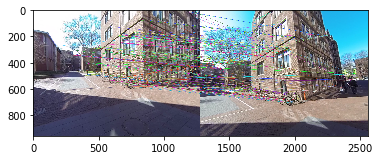

In [2]:
#image  cis.upenn.edu/~cis580/Spring2015/Projects/proj2/SfMProjectData.zip

img1 = cv2.imread('image0000001.bmp')
img2 = cv2.imread('image0000002.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create(edgeThreshold=3)

# find the keypoints with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)

plt.imshow(img3)
plt.show()

In [3]:
import random
import scipy.linalg
import torch
import torch.nn as nn
#Normalized 8-point algorithm

class LinearLeastSquaresModel():

    def __init__(self, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device    
        self.MSE = nn.MSELoss(reduction='none')
        #value will be assigned after calling fit
        self.x = None
        
    def fit(self, data, T1, T2):
        _, _, Vh = scipy.linalg.svd(data)
        #(Hermitian) transpose back
        x = Vh.transpose()[:, -1];
        U, D, Vh = scipy.linalg.svd(x.reshape((3, 3)))
        F = U @ np.diag(np.array([D[1], D[2], 0])) @ Vh
        F = T2.transpose() @ F @ T1
        self.x = torch.tensor(F).view(9).to(self.device);
        return F
    
    def calc_err(self, data):
        batch_size = data.shape[0]
        compute_result = (data @ self.x)
        err = self.MSE(compute_result, torch.zeros((batch_size), dtype=torch.float64).to(self.device))
        return err

def EstimateFundamentalMatrix(sample_points, T1, T2, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    LSmodel = LinearLeastSquaresModel(device = device)
    F = LSmodel.fit(np.array(sample_points), T1, T2)
 
    return F, LSmodel    
    


def convert2Homogeneous(a):
    temp = np.zeros((3,len(a)))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        temp[0][i] = x1
        temp[1][i] = y1
        temp[2][i] = 1
    return temp

def normalise2dpts(pts):
    """
    based on http://pydoc.net/ippe/0.0.1/ippe.homo2d/
    Function translates and normalises a set of 2D homogeneous points 
    so that their centroid is at the origin and their mean distance from 
    the origin is sqrt(2).  This process typically improves the
    conditioning of any equations used to solve homographies, fundamental
    matrices etc.
       
       
    Inputs:
    pts: 3xN array of 2D homogeneous coordinates
   
    Returns:
    newpts: 3xN array of transformed 2D homogeneous coordinates.  The
            scaling parameter is normalised to 1 unless the point is at
            infinity. 
    T: The 3x3 transformation matrix, newpts = T*pts
    """
    if pts.shape[0] != 3:
        print("Input shoud be 3")

    finiteind = np.nonzero(abs(pts[2,:]) > np.spacing(1));
    
    if len(finiteind) != pts.shape[1]:
        print('WARNING(normalise2dpts): Some points are at infinity')
    
    dist = []
    for i in finiteind:
        pts[0,i] = pts[0,i]/pts[2,i]
        pts[1,i] = pts[1,i]/pts[2,i]
        pts[2,i] = 1;

        c = np.mean(pts[0:2,i].T, axis=0).T          

        newp1 = pts[0,i]-c[0]
        newp2 = pts[1,i]-c[1]
    
        dist.append(np.sqrt(newp1**2 + newp2**2))

    meandist = np.mean(dist[:])
    
    scale = np.sqrt(2)/meandist
    
    T = np.array([[scale, 0, -scale*c[0]], [0, scale, -scale*c[1]], [0, 0, 1]])
    
    newpts = T.dot(pts)
    return [newpts, T]

def transform(a,b):
    #####
    #input shape: [batch, [x, y, 1]]
    #return: list 
    #        shape: [batch, [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]]
    #####
    mat = []
    assert(len(a)==len(b))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        x2 = b[i][0]
        y2 = b[i][1]
        mat.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    return mat

    
def RANSAC(trainPoints, queryPoints, max_iter_times = 1000000, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    
    t = time.time()
    x1, T1 = normalise2dpts(convert2Homogeneous(trainPoints))
    x2, T2 = normalise2dpts(convert2Homogeneous(queryPoints))
    data = transform(x1.transpose(), x2.transpose())
    
    iterations = 0
    batches = torch.tensor(data, dtype=torch.float64).to(device)
    
    batch_size = batches.shape[0]
    
    episilon = batches.new_full((1, batch_size), 0.00001).view(batch_size).to(device)
    train_inliers = []
    query_inliers = []
    
    while iterations < max_iter_times:

        sample_points = random.sample(data, 8)
        F, LSmodel = EstimateFundamentalMatrix(sample_points, T1, T2, device)
        err = LSmodel.calc_err(batches)
        if((err < episilon).float().mean().item() > 0.98):           
            ind = np.where((err.cpu()<episilon.cpu()))
            train_inliers = trainPoints[ind]
            query_inliers = queryPoints[ind]
            break
        iterations += 1
        
    print('[RANSAC] takes ', time.time() - t,'sec')
    print('[RANSAC] iteration', iterations,' err:', err.mean().item())     
    if(iterations == max_iter_times):
        print("no result found by RANSAC")
    
    return F, train_inliers, query_inliers, ind

In [4]:
trainPoints = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
queryPoints = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
pts1 = np.int32(trainPoints)
pts2 = np.int32(queryPoints)

In [5]:
my_F, train_inliers, query_inliers, ind = RANSAC(pts1, pts2, max_iter_times = 1000000) 

WARNING(normalise2dpts): Some points are at infinity
WARNING(normalise2dpts): Some points are at infinity
[RANSAC] takes  1.5473241806030273 sec
[RANSAC] iteration 337  err: 1.7510132272594693e-06


In [6]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    (r,c,_) = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

my Fundamental matrix


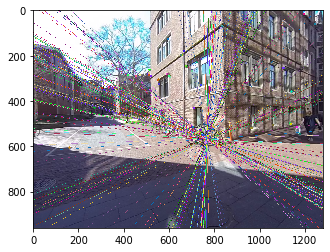

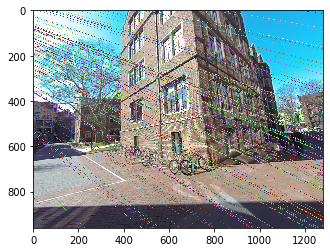

In [7]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(query_inliers.reshape(-1,1,2), 2, my_F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1.copy(),img2.copy(),lines1,train_inliers,query_inliers)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(train_inliers.reshape(-1,1,2), 1, my_F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2.copy(),img1.copy(),lines2,query_inliers,train_inliers)
print("my Fundamental matrix")
plt.imshow(img5)
plt.show()
plt.imshow(img3)
plt.show()

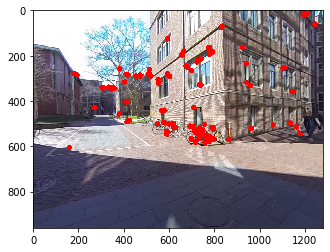

my inliers


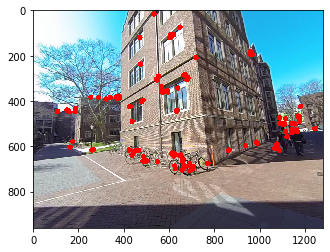

In [8]:
imageA = img1.copy()
imageB = img2.copy()
for i in train_inliers:
    imageA = cv2.circle(imageA , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
for i in query_inliers:
    imageB = cv2.circle(imageB , (int(i[0]), int(i[1])), 2, (255, 0, 0), 20)
print("my inliers")
plt.imshow(imageB)
plt.show()


In [9]:
f1 = 568.996140852
f2 = 568.988362396
s = 0
mx = my = 1
px = 643.21055941
py = 477.982801038
K = np.array([[f1*mx, s, px],[0, f2*my, py], [0, 0, 1]])
W = np.array([[0, -1, 0],[1, 0 ,0], [0, 0, 1]])
eps = 1e-12

In [10]:
def getEssentialMatrix(F):
    E = K.transpose() @ F @ K
    return E
def getEssentialConfig(E):
    U, D, Vh = scipy.linalg.svd(E)
    return U, D, Vh

In [11]:
def CameraPosition1Config(U, D, Vh):
    R1 = U @ W @ Vh
    C1 = U[:,2]
    det = np.linalg.det(R1)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C1 = -C1
        R1 = -R1 
    return C1, R1

def CameraPosition2Config(U, D, Vh):
    R2 = U @ W @ Vh
    C2 = -U[:,2]
    det = np.linalg.det(R2)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C2 = -C2
        R2 = -R2    
    return C2, R2

def CameraPosition3Config(U, D, Vh):
    R3 = U @ W.transpose() @ Vh
    C3 = U[:,2]
    det = np.linalg.det(R3)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C3 = -C3
        R3 = -R3
    return C3, R3    
        
def CameraPosition4Config(U, D, Vh):
    R4 = U @ W.transpose() @ Vh
    C4 = -U[:,2]
    det = np.linalg.det(R4)
    if det != 1:
        assert(abs(det) <= 1 + eps)
        C4 = -C4
        R4 = -R4
    return C4, R4

In [12]:
def CameraPoseMatrix(K, R, C):
    return K @ R @ np.array([[1,0,0, -C[0]],[0,1,0, -C[1]],[0,0,1, -C[2]]])

In [13]:
def getCameraMatrix(K, R0, C0, R1, C1):
    #first camera
    P1 = CameraPoseMatrix(K, R0, C0)#K @ R0 @ np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

    #second camera
    E = U @ np.array([[1,0,0],[0,1,0],[0,0,0]]) @ Vh
    P2 = CameraPoseMatrix(K, R1, C1) #np.concatenate((R1, -C1.reshape(3,1)), axis=1)
    return P1, P2

In [14]:
from scipy.linalg import lstsq
from scipy.optimize import lsq_linear

def LinearTriangulation(v1, v2, P1, P2):
    row1 = v1[0]*P1[2,:] - P1[1,:]
    row2 = v1[1]*P1[2,:] - P1[0,:]
    row3 = v2[0]*P2[2,:] - P2[1,:]
    row4 = v2[1]*P2[2,:] - P2[0,:]
    #row5 = np.array([1,1,1,1])
    A = np.array([row1,row2,row3,row4])
    b = np.array([0,0,0,0])
    res = lsq_linear(A, b, bounds=([-1000,-1000,-1000,1], [1000,1000,1000,1.0001]),lsmr_tol='auto')
    return res.x

In [15]:
def getWorldPoints(train_inliers, query_inliers, P1, P2):
    points = []
    for (train_inlier, query_inlier) in zip(train_inliers, query_inliers):
        points.append(LinearTriangulation(train_inlier, query_inlier, P1, P2))
    return np.array(points)

In [16]:
def CheckCheirality(points, C1, R1, C2, R2):
    n_in_front_of_C1 = 0
    n_in_front_of_C2 = 0
    for point in points:
        point = point[0:3]
        if(R1[2,:].dot(point-C1)>0):
            n_in_front_of_C1 +=1
        if(R2[2,:].dot(point-C2)>0):
            n_in_front_of_C2 +=1
    return n_in_front_of_C1, n_in_front_of_C2

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

my F results
len(points): 178


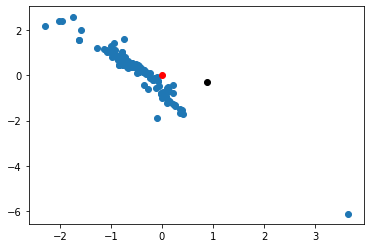

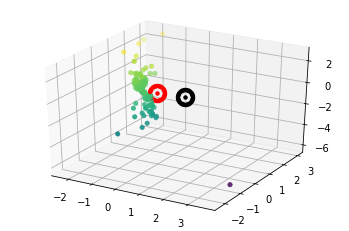

In [18]:
print('my F results')

E = getEssentialMatrix(my_F)
U, D, Vh = getEssentialConfig(E)

#first camera
C0 = np.array([0,0,0])
R0 = np.array([[1,0,0],[0,1,0],[0,0,1]])

#second camera
C1, R1 = CameraPosition1Config(U, D, Vh)
C2, R2 = CameraPosition2Config(U, D, Vh)
C3, R3 = CameraPosition3Config(U, D, Vh)
C4, R4 = CameraPosition4Config(U, D, Vh)
Cs = [C1,C2,C3,C4]
Rs = [R1,R2,R3,R4]

best_ct = 0
best_secondCamera_C = None
best_secondCamera_R = None
points = None

for C,R in zip(Cs, Rs):
    P1, P2 = getCameraMatrix(K, R0, C0, R, C)    
    temp_points = getWorldPoints(train_inliers, query_inliers, P1, P2)
    n_in_front_of_C1, n_in_front_of_C2 = CheckCheirality(temp_points, C1, R1, C2, R2)
    if(n_in_front_of_C1 + n_in_front_of_C2 > best_ct):
        best_ct = n_in_front_of_C1 + n_in_front_of_C2
        best_secondCamera_C = C
        best_secondCamera_R = R
        points = temp_points
#print("max points in front of both cameras:", best_ct)
print("len(points):",len(points))
#XZ
plt.scatter(points[:,0], points[:,2])
plt.scatter(C0[0], C0[2], c='red')
plt.scatter(C1[0], C1[2], c='black')
plt.show()
ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,2], cmap='viridis', linewidth=0.5);
ax.scatter(C0[0], C0[1], C0[2], c='red', linewidth=15);
ax.scatter(C1[0], C1[1], C1[2], c='black', linewidth=15);
plt.show()